In [111]:
import torch 
import torch.nn as nn

In [112]:
class ACNet(nn.Module):
    def __init__(self,q):
        self.lay = 200;
        super(ACNet,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay, self.lay),
            nn.Tanh(),
            nn.Linear( self.lay,q+1)
        )
        tmp = np.float32(np.loadtxt('Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]

    def forward(self, x):
        x = self.net(x)
        return x

    # loss function
    def MSE(self,ypred,ytrue):
        return torch.mean((ypred - ytrue)**2) 

    # Glorot initialization of weight matrix
    def glorot_init_mat(self,shape):
        din = shape[0]
        dout = shape[1]
        var = torch.tensor([2.0/(din+dout)])
        std = torch.sqrt(var)
        mean = torch.tensor([0.0])
        dist = torch.distributions.normal.Normal(mean, std)
        return dist.sample(shape)

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyDOE import lhs
import argparse
import scipy.io

In [114]:
parser = argparse.ArgumentParser()
parser.add_argument("--epochs", help="Number of epochs to train neural network for")

"""data prep"""
"""
DE: u_t-0.0001*u_{xx}+5*u^3-5*u=0
"""
args = parser.parse_args(['--epochs','1000'])

In [115]:
data = scipy.io.loadmat('Data/AC.mat')
    
t = data['tt'].flatten()[:,None]#T x 1
x = data['x'].flatten()[:,None]# N x 1
Exact = np.real(data['uu'])#N x T

In [123]:
N, q = 200,100
# Doman bounds
lb = np.array([-1.0])
ub = np.array([1.0])

idx_t0 = 20
idx_t1 = 180
dt = t[idx_t1] - t[idx_t0]
# Generate samples for x, t
#sample points
#noise_u0 = 0.0
idx_x = np.random.choice(Exact.shape[0], N, replace=False) 
x0 = x[idx_x,:]
u0 = Exact[idx_x, idx_t0:idx_t0+1]
#u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])

# Boudanry data
x1 = np.vstack((lb,ub))
x_star = x
u_star = Exact[:, idx_t1:idx_t1+1]

In [124]:

"""NN class, init, loss functions, dataloader"""

# %%
"""training process"""

# %%
#load u0
u0 = u0.reshape((-1, 1))
u0 = torch.tensor(u0).type(torch.FloatTensor)
# load x, t data into torch
x0 = x0.reshape((-1, 1))
x0 = torch.tensor(x0).type(torch.FloatTensor)

x1 = x1.reshape((-1, 1))
ab = torch.tensor(pn.IRK_weights).type(torch.FloatTensor)
c = torch.tensor(pn.IRK_times).type(torch.FloatTensor)

In [125]:
# %%
#Instantiate class
pn = ACNet(q)
x1 = torch.tensor(x1).type(torch.FloatTensor)
#Initialize weights
#Glorot initialization
[W, b] = list(pn.net[0].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[2].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[4].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[6].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[8].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])

In [126]:
# %%
# Perform backprop
MAX_EPOCHS = int(args.epochs)
LRATE = 3e-4

#Use Adam for training
optimizer = torch.optim.Adam(pn.parameters(), lr=LRATE)

loss_history_ic = []
loss_history_bc = []
loss_history = []

In [127]:
import time
start_time = time.time()
for epoch in range(MAX_EPOCHS):
    xc = x0.clone()
    xc.requires_grad = True
    #full batch

    #initial condition
    U = pn(xc)
    Uc = U[:,:-1]
    Ucx = torch.autograd.grad(Uc.sum(),xc,create_graph=True)[0]
    Ucxx = torch.autograd.grad(Ucx.sum(),xc,create_graph=True)[0]
    F = -0.0001*Ucxx + 5*Uc**3 - 5*Uc
    u0_pred = U - torch.Tensor(dt)*F.mm(ab.transpose(0,1))
    mse_ic = pn.MSE(u0_pred, u0)
    loss_history_ic.append([epoch, mse_ic])
    
    #boundary condition
    x1c = x1.clone()
    x1c.requires_grad = True
    Ub_pred = pn(x1c)
    Ub_pred1 = torch.autograd.grad(Ub_pred.sum(),x1c,create_graph=True)[0]
    mse_bc = pn.MSE(Ub_pred[0:1,:], Ub_pred[1:2,:])+ pn.MSE(Ub_pred1[0:1,:], Ub_pred1[1:2,:])
    loss_history_bc.append([epoch, mse_bc])

    loss = mse_ic + mse_bc
    loss_history.append([epoch, loss])

    #optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print("Epoch: {}, MSE_ic: {:.4f}, MSE_bc: {:.4f}, MSE_f: {:.4f}, MSE: {:.4f}".format((epoch+1), mse_ic, mse_bc, mse_f, loss))
elapsed = time.time() - start_time

Epoch: 1000, MSE_ic: 0.0712, MSE_bc: 0.0199, MSE_f: 0.0131, MSE: 0.0912


In [128]:
#%%
#save trained model
fname = "ACNet_{}.pt".format(MAX_EPOCHS)
torch.save(pn, fname)

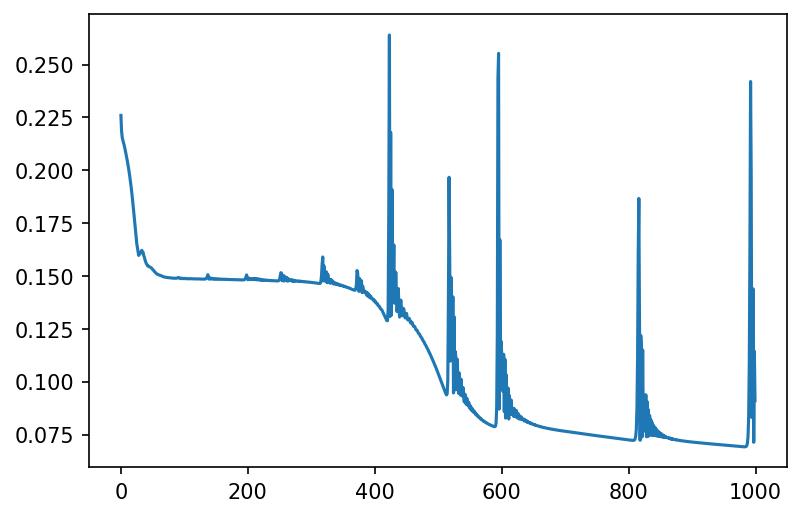

In [129]:
#%%
loss_history = np.array(loss_history)
plt.figure(dpi=150)
plt.plot(loss_history[:,0], loss_history[:,1])
#plt.savefig("ACNet_loss_hist_{}.png".format(MAX_EPOCHS))
#plt.show()

<ipython-input-131-2dd6e11db27a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).type(torch.FloatTensor)


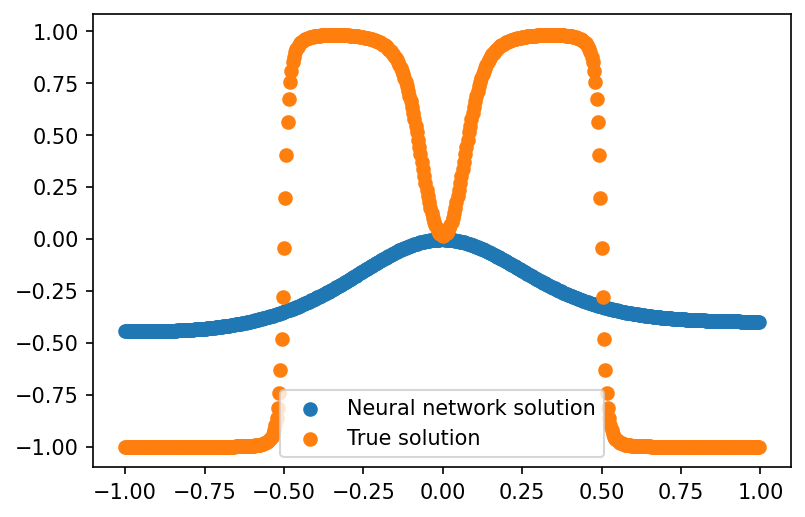

In [131]:
#%%
plt.figure(dpi=150)
x = torch.tensor(x).type(torch.FloatTensor)
xc = x.clone()
xc.requires_grad = True
U_pred = pn(xc)
Uc = U_pred[:,:-1]
Ucx = torch.autograd.grad(Uc.sum(),xc,create_graph=True)[0]
Ucxx = torch.autograd.grad(Ucx.sum(),xc,create_graph=True)[0]
F = -0.0001*Ucxx + 5*Uc**3 - 5*Uc
u0_pred = U_pred - torch.Tensor(dt)*F.mm(ab.transpose(0,1))
u0_pred = u0_pred[:,0:1]
plt.scatter(x.data.numpy(), u0_pred.data.numpy(), label="Neural network solution")
plt.scatter(x.data.numpy(), u_star, label="True solution")
plt.legend()
#plt.savefig("PINN_soln_comp_{}.png".format(N_f))
#plt.show()